# Imports

In [1]:
#!wget http://purl.obolibrary.org/obo/go.obo
import pandas
import numpy
import requests,math,pickle
import networkx,obonet
import numpy as np ,pandas as pd, matplotlib.pyplot as plt
import arabic_reshaper
import multiprocessing as mp
import scipy.stats as stats
from bidi.algorithm import get_display
from functools import partial
import sys
import gc
import mysql.connector
from IPython.display import clear_output
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

# Variables

In [2]:
dataset_name = "CAMI_Low"
num_cores = max(mp.cpu_count() - 1, 1)
!mkdir -p ./Output/{dataset_name}/figs
!mkdir -p ./Temp/{dataset_name}/

In [3]:
def to_biobox(df, path):
    df[df["bin_id"]!= 0].to_csv(path, index=None, sep='\t',header=None)    
    with open(path, 'r') as file:        
        text = file.read()
    with open(path, 'w', encoding='utf8') as file:
        file.write("@Version:0.9.1\n@SampleID:gsa\n\n@@SEQUENCEID\tBINID\n" + text)

# MySQL

## Create database

In [4]:
db = mysql.connector.connect(host="localhost",user="ilia",password="Connect2Mysql!@#")
cursor = db.cursor()
cursor.execute(f"DROP DATABASE  IF EXISTS Improver_{dataset_name};")
cursor.execute(f"CREATE DATABASE Improver_{dataset_name}")
cursor.execute(f"USE Improver_{dataset_name}")

cursor.execute('''CREATE TABLE Sequence (seq_id VARCHAR(100) NOT NULL,                                   
                                     length INT,
                                     PRIMARY KEY (seq_id))''')

cursor.execute('''CREATE TABLE GO (go_id CHAR(10) NOT NULL,                                   
                                     namespace VARCHAR(30),
                                     PRIMARY KEY (go_id))''')

cursor.execute('''CREATE TABLE Seq_GO (seq_id VARCHAR(100) NOT NULL,                               
                                       go_id CHAR(10) NOT NULL,   
                                     FOREIGN KEY (seq_id) REFERENCES Sequence(seq_id),
                                     FOREIGN KEY (go_id) REFERENCES GO(go_id))''')

cursor.execute('''CREATE TABLE Base (seq_id VARCHAR(100)  NOT NULL,                                   
                                     bin_id INT,
                                     FOREIGN KEY (seq_id) REFERENCES Sequence(seq_id))''')

cursor.execute('''CREATE TABLE Go_scores (go_id1 CHAR(10) NOT NULL,
                                     go_id2 CHAR(10) NOT NULL,
                                     score FLOAT,
                                     FOREIGN KEY (go_id1) REFERENCES GO(go_id),
                                     FOREIGN KEY (go_id2) REFERENCES GO(go_id))''')
db.disconnect()

## Connect to DB

In [5]:
def get_connect():
    db = mysql.connector.connect(host="localhost",user="ilia",password="Connect2Mysql!@#",
         database=f"Improver_{dataset_name}")
    return db

# Read Fasta

In [6]:
def fasta_to_df(path):
    with open(path, 'r') as file:
        text = file.read()
    lines = [line for line in text.split('\n') if len(line) > 0]
    s = ''
    ids = []
    contigs = []
    for l in lines:
        if(l[0]=='>'):
            ids.append(l)        
            contigs.append(s)
            s = ''
        else:
            s += l    
    contigs.append(s)
    df = pd.DataFrame(
            {
                '#anonymous_gsa_id': ids,
                'contig': contigs[1:]
            })
    df['#anonymous_gsa_id'] = df['#anonymous_gsa_id'].apply(lambda x: x[1:])    
    return df

In [7]:
contigs = fasta_to_df(f"./Dataset/{dataset_name}/contigs.fna")
all_number = contigs.shape[0]
contigs["contig_length"] = contigs["contig"].apply(lambda x: len(x))
del contigs['contig']
contigs.head(2)

,#anonymous_gsa_id,contig_length
0,RL|S1|C0,809
1,RL|S1|C1,626


In [9]:
db = get_connect()
cursor = db.cursor()
contigs.apply(lambda row : cursor.execute(\
f'''INSERT INTO Sequence (seq_id, length) 
VALUES ('{row['#anonymous_gsa_id']}'
       , {row['contig_length']})'''),axis=1)
db.commit()
db.disconnect()

In [10]:
df = pd.read_csv(f"./Dataset/{dataset_name}/mapping.tsv", sep='\t')
contigs = pd.merge(contigs, df, how='inner', on='#anonymous_gsa_id')
contigs.head(2)

,#anonymous_gsa_id,contig_length,bin_id,tax_id,sequence_id,number_reads
0,RL|S1|C0,809,1220_AJ,75309,scaffold5.1_1_from_14912_to_15720_total_809,12
1,RL|S1|C1,626,1048993,328515,scaffold00001_11_from_606387_to_607012_total_626,16


# Save gold standard data as CAMI binning Bioboxes format.

In [11]:
path = f"./Temp/{dataset_name}/gold_standard"
contigs[['#anonymous_gsa_id', 'bin_id', 'tax_id',
         'contig_length']].to_csv(path, index=None, sep='\t')

with open(path, 'r') as file:
    file.readline()
    text = file.read()

with open(path, 'w', encoding='utf8') as file:
    file.write("@Version:0.9.1\n@SampleID:gsa\n\n@@SEQUENCEID\tBINID\tTAXID\t_LENGTH\n"+ text)

# Base Algorithms

In [12]:
def get_base_bin(bin_name, prob=0):
    try:
        df = pd.read_csv(f"./Binning/{dataset_name}/{bin_name}/prob{prob}/contigs.tab", sep='\t', header = None)
        df.columns = ['#anonymous_gsa_id','bin_id']
        df = df[df["bin_id"]!= 0]
        to_biobox(df, f"./Temp/{dataset_name}/{bin_name}_p{prob}")
        print(f'binned contigs: {df.shape[0]}', f'{round(df.shape[0]*100 / all_number,2)}% assigned')    
        display(df.head(2))
        return df
    except Exception as e:
        print(e)
        return None

In [14]:
base = get_base_bin('Metabat2',95) # Busybee, Metabat1, Metabat2, Maxbin2

binned contigs: 1687 8.65% assigned


,#anonymous_gsa_id,bin_id
0,RL|S1|C6180,1
1,RL|S1|C7437,1


In [15]:
db = get_connect()
cursor = db.cursor()
base.apply(lambda row : cursor.execute(\
f'''INSERT INTO Base (seq_id, bin_id) 
VALUES ('{row['#anonymous_gsa_id']}'
       , {row['bin_id']})'''),axis=1)
db.commit()
db.disconnect()

# Gene Ontology

In [16]:
go = pd.read_csv(f"./Annotation/{dataset_name}/cds.gene2go.tab.txt", sep='\t')
go = go.reset_index(drop=True)
go = go[['#Gene','TM']]
go.head(2)

,#Gene,TM
0,RL|S1|C13963,GO:0016811
1,RL|S1|C13963,GO:0019740


## Add namespace [ cc, bp, mf ]

In [17]:
go_graph = obonet.read_obo('./go.obo') 
accession_to_namespace = dict()
go_ids = go['TM'].unique()
for accession in go_ids:
    try:        
        accession_to_namespace[accession] =  go_graph.nodes[accession]['namespace']
    except: 
        accession_to_namespace[accession] = "unknown"

In [18]:
def get_namespace(accession):
    if(accession in accession_to_namespace):        
        return accession_to_namespace[accession]    
    return "unknown"

go['Namespace'] = go['TM'].apply(lambda x : get_namespace(x) )
print(go['Namespace'].value_counts())
go.head(2)

molecular_function    194760
biological_process    129305
cellular_component     78988
unknown                11250
Name: Namespace, dtype: int64


,#Gene,TM,Namespace
0,RL|S1|C13963,GO:0016811,molecular_function
1,RL|S1|C13963,GO:0019740,biological_process


In [19]:
db = get_connect()
cursor = db.cursor()

go.groupby('TM').first().apply(lambda row: cursor.execute(\
f'''INSERT INTO GO (go_id, namespace) 
VALUES ('{row.name}'
       , '{row['Namespace']}')'''),axis=1)
db.commit()
db.disconnect()

In [20]:
db = get_connect()
cursor = db.cursor()

go.apply(lambda row: cursor.execute(\
f'''INSERT INTO Seq_GO (seq_id, go_id) 
VALUES ('{row['#Gene']}'
       , '{row['TM']}')'''),axis=1)
db.commit()
db.disconnect()

# Improver Method

## Create dictionary BP, CC , MF base of GOGO for each pair of go ids

In [21]:
def runGOGO(i,namespace):        
    %cd ./GOGO/
    !perl go_comb.pl ../Temp/{dataset_name}/{namespace}/go_ids{i}.txt ../Temp/{dataset_name}/{namespace}/go_ids_scores{i}
    %cd ..    

In [22]:
def Step1(namespace):    
    !rm -r ./Temp/{dataset_name}/{namespace}/ 
    !mkdir ./Temp/{dataset_name}/{namespace}/
    # first create all possible pairs of GOs for Biological Process        
    go_ids = go[go["Namespace"] == namespace]
    
    unlabelled = contigs[~contigs['#anonymous_gsa_id'].isin(base['#anonymous_gsa_id'])]
    unlabelledContigs = pd.Series(list(set(unlabelled['#anonymous_gsa_id']).intersection(set(go_ids['#Gene']))))            
    unlabeled_go = go_ids[go_ids['#Gene'].isin(unlabelledContigs)]['TM'].unique()
    unlabeled_go = pd.DataFrame(unlabeled_go, columns=['goid1'])
    
    labelled = contigs[contigs['#anonymous_gsa_id'].isin(base['#anonymous_gsa_id'])]
    labelledContigs = pd.Series(list(set(labelled['#anonymous_gsa_id']).intersection(set(go_ids['#Gene']))))            
    labeled_go = go_ids[go_ids['#Gene'].isin(labelledContigs)]['TM'].unique()
    labeled_go = pd.DataFrame(labeled_go, columns=['goid2'])
            
                    
    df = unlabeled_go.merge(labeled_go, how='cross')    
    indexes = np.linspace(0,df.shape[0], num_cores + 1) // 1
    indexes[-1] =  df.shape[0]
    
    for i in range(0, num_cores):
        dfi = df.iloc[int(indexes[i]):int(indexes[i+1]),:]
        dfi.to_csv(f"./Temp/{dataset_name}/{namespace}/go_ids{i}.txt",sep=" ",index=None,header=None)
        
    # now run GOGO in multiprocessing
    if __name__ == '__main__':        
        pool = mp.Pool(num_cores)        
        pool.map(partial(runGOGO, namespace=namespace), range(0,num_cores))      
        
    clear_output()

In [23]:
def pd2sql(i, namespace):
    lines = []    
    with open(f"./Temp/{dataset_name}/{namespace}/go_ids_scores{i}","r") as f:
        text = f.read()
        lines = [*lines, *[l for l in text.split("\n") if len(l) > 0 and l[-24:] != "not_in_the_same_ontology"]]                            
    df = pd.read_csv(StringIO('\n'.join(lines)), sep=" ", header=None)    
    df.columns = ['go_id1', 'go_id2', 'namespace', 'score']    
    db = get_connect()
    cursor = db.cursor()
    df.apply(lambda row: cursor.execute(\
        f'''INSERT INTO Go_scores (go_id1, go_id2, score) 
            VALUES ('{row['go_id1']}',
            '{row['go_id2']}',
            {row['score']})'''),axis=1)
    db.commit()
    db.disconnect()
    
def Step2(namespace):                                
    if __name__ == '__main__':        
        pool = mp.Pool(num_cores)        
        pool.map(partial(pd2sql, namespace=namespace), range(0, num_cores))      
    #!rm -r ./Temp/{dataset_name}/{namespace}/    

### biological process

In [156]:
Step1("biological_process")

In [24]:
Step2("biological_process")

### cellular component

In [25]:
Step1("cellular_component")

In [26]:
Step2("cellular_component")

### molecular function

In [27]:
Step1("molecular_function")

In [28]:
Step2("molecular_function")

## Main loop

In [32]:
unlabelled = contigs[~contigs['#anonymous_gsa_id'].isin(base['#anonymous_gsa_id'])]
unlabelled
#unlabelledContigs = pd.Series(list(set(unlabelled['#anonymous_gsa_id']).intersection(set(go['#Gene']))))            
#unlabelledContigs

,#anonymous_gsa_id,contig_length,bin_id,tax_id,sequence_id,number_reads
0,RL|S1|C0,809,1220_AJ,75309,scaffold5.1_1_from_14912_to_15720_total_809,12
1,RL|S1|C1,626,1048993,328515,scaffold00001_11_from_606387_to_607012_total_626,16
2,RL|S1|C2,9870,1036743,1120996,scaffold00002_17_from_433871_to_443740_total_9870,320
3,RL|S1|C3,950,1365_A,29580,scaffold4.1_4_from_315635_to_316584_total_950,24
4,RL|S1|C4,820,evo_1049056.039,1004304,contig_4_1_from_136770_to_137589_total_820,12
...,...,...,...,...,...,...
19493,RL|S1|C19493,295,1220_AJ,75309,scaffold2.1_1_from_517462_to_517756_total_295,2
19494,RL|S1|C19494,150,1220_AJ,75309,scaffold2.1_1_from_837247_to_837396_total_150,1
19495,RL|S1|C19495,4113,1035900,644383,scaffold00071_from_1_to_4113_total_4113,4922
19496,RL|S1|C19496,361,1220_AJ,75309,scaffold1.1_1_from_372792_to_373152_total_361,4


In [42]:
def binScore(inp_bin, go_id, dictionary,portion):        
    go_id_rare = go_rare[go_id]
    def run(g):
        pair = g +  go_id                
        if(pair in dictionary):                                          
            return  dictionary[pair] #* portion * go_rare[g] * go_id_rare         
        return 0                
    scores = inp_bin.apply(lambda g: run(g))            
    #scores = scores[scores >= 0]            
    if(scores.shape[0] == 0):
        return 0
    st = sorted(scores,reverse=True)[:number]    
    return sum(st) / len(st)

def getScore(go_id):            
    result = numpy.zeros(number_of_bins)    
    namespace = accession_to_namespace[go_id]    
    for i in range(0,number_of_bins):
        result[i] = binScore(bins[i], go_id, getDictionary(namespace),bins_portion[i])    
    return go_id, result

In [43]:
#pool = mp.Pool(num_cores)    
go_ids = pd.merge(unlabelled, go, how='inner',
             left_on='#anonymous_gsa_id',right_on='#Gene')['TM'].unique()

## Pred

In [380]:
alpha = 1  # BP
beta  = 1  # CC
gamma = 1  # MF

def getCoefficient(namespace):
        if(namespace == "biological_process"):
            return alpha
        if(namespace == "cellular_component"):
            return beta    
        if(namespace == "molecular_function"):
            return gamma    
    
def pred(cnt):                                
    coeff = 0
    selected = go[go['#Gene'] == cnt]
    go_ids = selected['TM']                
    go_namespace = selected['Namespace']                
    result = np.zeros((go_ids.shape[0], number_of_bins))    
    for i in range(0,len(go_ids.index)):  
        index = go_ids.index[i]               
        namespace = go_namespace[index]        
        coeff += getCoefficient(namespace)                                         
        result[i,:] = go_dictionary[go_ids[index]] * getCoefficient(namespace)                     
    score = sum(result) / coeff if coeff != 0 else sum(result) * 0            
    index = np.where(score == max(score))[0][0] + 1                
    return index, max(score), cnt    

if __name__ == '__main__':
    answer = {}        
    pool = mp.Pool(num_cores)    
    unlabelledContigs = pd.Series(list(set(unlabelled['#anonymous_gsa_id']).intersection(set(go['#Gene']))))            
    for index, score, cnt in pool.map(pred,unlabelledContigs):        
        answer[cnt] = (index,  score)

{65, 22, 1}


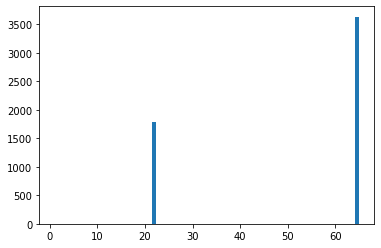

In [381]:
x = [v[0] for v in answer.values()]
plt.hist(x, bins=number_of_bins)
print(set(x))

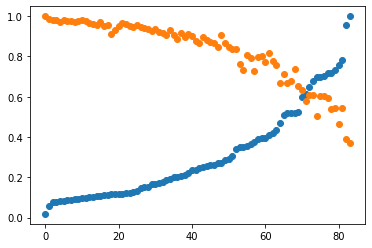

In [368]:
l = []
for i in range(len(bins)):
    l.append(len(bins[i]))

bin_size = np.array(l)/max(np.array(l))    
index = np.argsort(bin_size)
plt.plot([bin_size[i] for i in index],'o')
plt.plot([bins_portion[i] for i in index],'o')

In [377]:
threshold = sorted([i[1] for i in answer.values()], reverse=True)[3000]
print(threshold)
threshold = 0.15
counter = 0
def assign(row):
    global counter
    cnt = row['#anonymous_gsa_id']
    if(cnt in answer and answer[cnt][1] >= threshold):                
        counter += 1
        return answer[cnt][0]    
    return 0

unlabelled['pred'] = unlabelled.apply(lambda row:assign(row),axis=1)    
print(counter)

0.1275888000000001
2262


In [378]:
df = unlabelled[unlabelled['pred']!=0][['#anonymous_gsa_id','pred']]
df.columns = ['#anonymous_gsa_id','bin_id']
to_biobox(pd.concat([base,df]), f"./Temp/{dataset_name}/improved")

In [379]:
!amber.py -g ./Temp/{dataset_name}/gold_standard \
-o ./Output/{dataset_name}/Assesment \
./Temp/{dataset_name}/metabat1_p95 \
./Temp/{dataset_name}/metabat2_p95 \
./Temp/{dataset_name}/improved                  

2021-08-02 14:57:14,218 INFO Loading Gold standard
2021-08-02 14:57:14,270 INFO Loading metabat1_p95
2021-08-02 14:57:14,288 INFO Loading metabat2_p95
2021-08-02 14:57:14,300 INFO Loading improved
2021-08-02 14:57:14,317 INFO Creating output directories
2021-08-02 14:57:14,319 INFO Evaluating Gold standard (sample gsa, genome binning)
2021-08-02 14:57:14,517 INFO Evaluating metabat1_p95 (sample gsa, genome binning)
2021-08-02 14:57:14,726 INFO Evaluating metabat2_p95 (sample gsa, genome binning)
2021-08-02 14:57:14,928 INFO Evaluating improved (sample gsa, genome binning)
2021-08-02 14:57:15,122 INFO Saving computed metrics
2021-08-02 14:57:15,153 INFO Creating genome binning plots
/home/emadi/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=obj

# KEGG

In [ ]:
kegg = pd.read_csv('./Annotation/Toy_low/data/cds.gene2kegg.tab.txt',sep='\t')
print(kegg.shape)
kegg = pd.merge(kegg,Geneid2Contigid,how='inner',on='#Geneid')
kegg.head(2)

In [ ]:
print(np.median(list(kegg['Kegg_id'].value_counts())))
plt.plot(list(kegg['Kegg_id'].value_counts()))
plt.show()

# KO

In [ ]:
ko = pd.read_csv('./Annotation/Toy_low/data/cds.gene2ko.tab.txt',sep='\t')
print(ko.shape)
ko.head(5)

In [ ]:
print(np.median(list(ko['koid'].value_counts())))
plt.plot(list(ko['koid'].value_counts()))
plt.show()

In [ ]:
print(np.median(list(ko['Contig'].value_counts())))
plt.plot(list(ko['Contig'].value_counts()))
plt.show()

In [ ]:
df = pd.read_csv('./Annotation/Toy_low/data/cds.gene2sprot.tab.txt',sep='\t')
print(df.shape)
df.head(2)

In [ ]:
uniprot = pd.read_csv('./uniprot-filtered-reviewed-yes.tab',sep='\t')
print(uniprot.shape)
uniprot.head(2)

In [ ]:
df = pd.merge(uniprot,df,how='inner',left_on='Protein names',right_on='sprot_desc')
print(df.shape)
df.head(2)